In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import kagglehub
import os
import pickle
import pathlib
from sklearn.model_selection import train_test_split


# CARREGAMENTO E PREPARAÇÃO DOS DADOS 

print("Carregando e preparando o dataset...")
path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")
data_dir = pathlib.Path(os.path.join(path, '0 FaceImages'))

active_paths = list(data_dir.glob('Active Subjects/*.jpg'))
active_labels = [0] * len(active_paths) # 0 para 'alerta'
fatigue_paths = list(data_dir.glob('Fatigue Subjects/*.jpg'))
fatigue_labels = [1] * len(fatigue_paths) # 1 para 'fadiga'

all_image_paths = [str(p) for p in (active_paths + fatigue_paths)]
all_labels = active_labels + fatigue_labels

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

train_dataset = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(len(train_paths)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

#CONSTRUÇÃO DO MODELO 

model = models.Sequential()

#'input_shape' ajustado para o tamanho correto da imagem.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.GlobalAveragePooling2D(name='vetor_de_caracteristicas'))
model.add(layers.Dropout(0.5))

# Camada de saída ajustada para classificação binária.
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


#COMPILAÇÃO E TREINAMENTO 

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset
)

print("\nTreinamento concluído!")

Carregando e preparando o dataset...


c:\Users\luizc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vetor_de_caracteristicas        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 196ms/step - accuracy: 0.6465 - loss: 1.0386 - val_accuracy: 0.7621 - val_loss: 0.5745
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.7119 - loss: 0.5746 - val_accuracy: 0.7275 - val_loss: 0.5435
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - accuracy: 0.7279 - loss: 0.5426 - val_accuracy: 0.7829 - val_loss: 0.4918
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.7511 - loss: 0.5167 - val_accuracy: 0.7714 - val_loss: 0.4995
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.7567 - loss: 0.5080 - val_accuracy: 0.7818 - val_loss: 0.4919
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.7536 - loss: 0.5013 - val_accuracy: 0.7906 - val_loss: 0.4691
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - accuracy: 0.7655 - loss: 0.4808 - val_accuracy: 0.7264 - val_loss: 0.4746
Epoch 8/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.7708 - loss: 0

In [5]:
import pickle

MODELS_DIR = "saved_models"
HISTORIES_DIR = "historicos"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)   

model_seq_path = os.path.join(MODELS_DIR, 'modelo_sequencialv2.keras')
model.save(model_seq_path)

loaded_model = tf.keras.models.load_model(model_seq_path)
feature_extractor = tf.keras.models.Sequential(name="Extrator_Sequential")

#copiando as camadas até o 'vetor_de_caracteristicas'
for layer in loaded_model.layers:
    feature_extractor.add(layer)
    if layer.name == 'vetor_de_caracteristicas':
        break 

history_seq_path = os.path.join(HISTORIES_DIR, 'history_sequencial.pkl')
with open(history_seq_path, 'wb') as file:
    pickle.dump(history.history, file)
    
feature_extractor.summary()

Model: "Extrator_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vetor_de_caracteristicas        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

57/57 - 3s - 44ms/step - accuracy: 0.8141 - loss: 0.3913

Acurácia de validação final: 0.8141447305679321


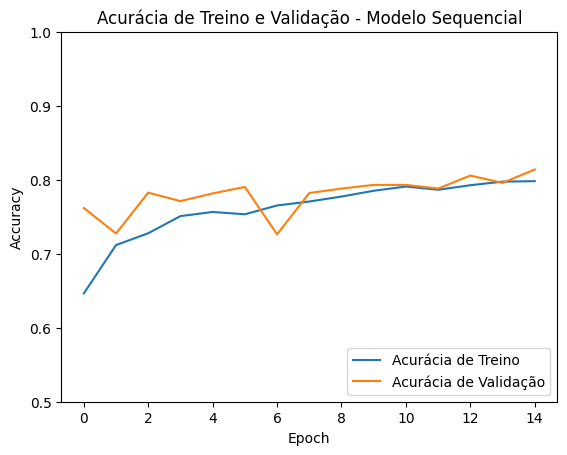

In [10]:
import matplotlib.pyplot as plt
import numpy as np


plt.title("Acurácia de Treino e Validação - Modelo Sequencial"  )
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(validation_dataset, verbose=2)

print("\nAcurácia de validação final:", val_acc)